In [1]:
import glob
import shutil
import random
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import uuid
import pandas as pd
from matplotlib import cm

d:\VSC Masterarbeit\tf-env\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# ==================== Konfiguration ====================
image_root = "balanced_dataset"
json_path = "JSONs/balanced_dataset_detections_60.json"
output_root = "augmented_dataset_new"
output_json_path = "JSONs/balanced_dataset_augmented.json"

augment_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [3]:
# ==================== JSON laden ====================
with open(json_path, "r") as f:
    data = json.load(f)

# Mapping Kategorie-ID → Name (nur gültige)
valid_category_names = set(os.listdir(image_root))
category_mapping = {cat["id"]: cat["name"] for cat in data["categories"] if cat["name"] in valid_category_names}

# Hilfs-Mapping
annotations_by_image = {ann["image_id"]: ann for ann in data["annotations"]}
detections_by_file = {img["file"]: img.get("detections", []) for img in data["images"]}

# Neue Einträge sammeln
new_images = []
new_annotations = []

In [5]:
# ==================== Verarbeitung pro Kategorie ====================
for category_id, category_name in category_mapping.items():
    print(f"\nKategorie: {category_name} (ID: {category_id})")

    # Bilder dieser Kategorie sammeln
    category_images = [img for img in data["images"]
                       if annotations_by_image.get(img["file"], {}).get("category_id") == category_id]

    print(f"- Originale Bilder: {len(category_images)}")

    if len(category_images) < 100:
        num_augments = min(300, 3 * len(category_images))
        print(f"- Ziel: {num_augments} augmentierte Bilder")

        for i in tqdm(range(num_augments), desc=f"Augmenting {category_name}"):
            img_entry = random.choice(category_images)
            img_path = os.path.join(image_root, img_entry["file"])

            if not os.path.exists(img_path):
                continue

            image = cv2.imread(img_path)
            h, w = image.shape[:2]

            # Bounding Boxes dieser Kategorie extrahieren
            bboxes = []
            categories = []
            
            for det in detections_by_file.get(img_entry["file"], []):
                x, y, bw, bh = det["bbox"]
                xc = x + bw / 2
                yc = y + bh / 2
                bboxes.append([xc, yc, bw, bh])
                categories.append(category_id)  # ← richtige Kategorie aus Annotation übernehmen

            if not bboxes:
                continue

            try:
                aug = augment_transform(image=image, bboxes=bboxes, category_ids=categories)
            except Exception as e:
                print(f"Augmentierungsfehler bei {img_path}: {e}")
                continue

            aug_img = aug["image"]
            aug_bboxes = aug["bboxes"]

            # Neuen Dateinamen und Pfad erstellen
            unique_name = str(uuid.uuid4())[:8]
            new_filename = f"{category_name}_aug_{unique_name}.jpg"
            save_dir = os.path.join(output_root, category_name)
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, new_filename)

            # Speichern
            cv2.imwrite(save_path, aug_img)

            # Relativer Pfad für neuen JSON-Eintrag
            rel_file_path = os.path.relpath(save_path, image_root)

            # Neue Image-Entry
            new_images.append({
                "file": rel_file_path,
                "detections": [{
                    "category": str(category_id),
                    "conf": 1.0,
                    "bbox": [
                        round(xc - bw / 2, 4),
                        round(yc - bh / 2, 4),
                        round(bw, 4),
                        round(bh, 4)
                    ]
                } for xc, yc, bw, bh in aug_bboxes]
            })

            # Neue Annotation
            new_annotations.append({
                "image_id": rel_file_path,
                "id": f"{rel_file_path}:ann_00",
                "sequence_level_annotation": False,
                "category_id": category_id
            })

# ==================== Daten aktualisieren ====================
data["images"].extend(new_images)
data["annotations"].extend(new_annotations)

# Neue JSON speichern
with open(output_json_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"\n✅ Augmentierung abgeschlossen. Neue JSON gespeichert unter: {output_json_path}")


Kategorie: acinonyx jubatus (ID: 0)
- Originale Bilder: 409

Kategorie: antidorcas marsupialis (ID: 2)
- Originale Bilder: 498

Kategorie: canis mesomelas (ID: 5)
- Originale Bilder: 485

Kategorie: cn-francolins (ID: 6)
- Originale Bilder: 73
- Ziel: 219 augmentierte Bilder


Augmenting cn-francolins:   0%|          | 0/219 [00:00<?, ?it/s]

Augmenting cn-francolins:  21%|██        | 45/219 [00:05<00:20,  8.49it/s]


KeyboardInterrupt: 

In [6]:
# Anzahl der augmentierten Bilder
print(f"Anzahl augmentierter Bilder: {len(new_images)}")



Anzahl augmentierter Bilder: 45


C:\Users\vogel\AppData\Local\Temp\ipykernel_21960\171956342.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


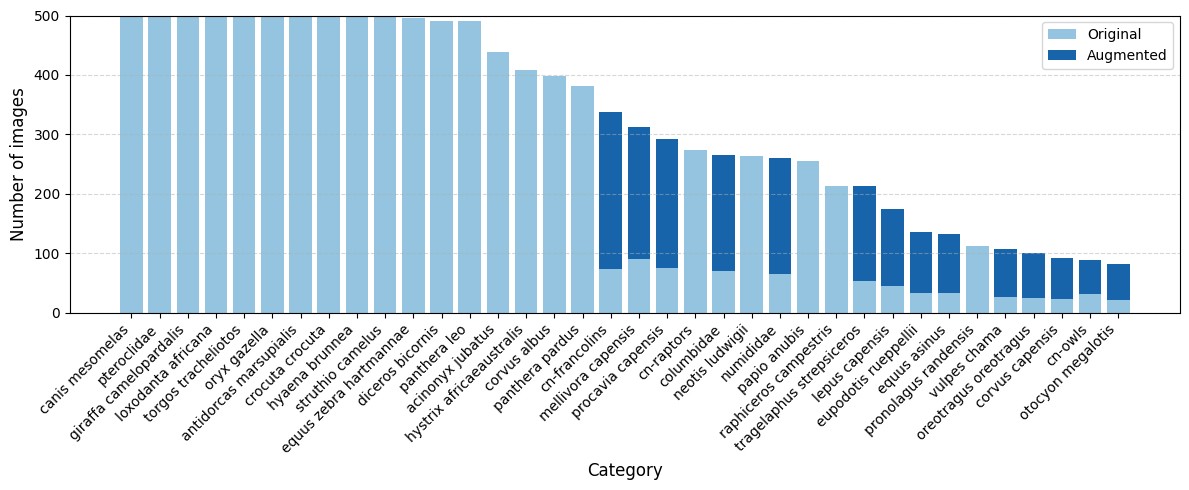

In [3]:
# Visualisierung der Verteilung der Original- und augmentierten Bilder pro Kategorie
def count_images_recursive(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    return count


image_root = "balanced_dataset"
aug_root = "augmented_dataset_new"


category_names = sorted(os.listdir(image_root))

original_counts = []
augmented_counts = []

for category in category_names:
    orig_path = os.path.join(image_root, category)
    aug_path = os.path.join(aug_root, category)

    orig_count = count_images_recursive(orig_path)
    aug_count = count_images_recursive(aug_path)

    original_counts.append(orig_count)
    augmented_counts.append(aug_count)


df_counts = pd.DataFrame({
    "Kategorie": category_names,
    "Original": original_counts,
    "Augmentiert": augmented_counts
})

# Sortieren nach Gesamtanzahl (absteigend)
df_counts["Total"] = df_counts["Original"] + df_counts["Augmentiert"]
df_counts = df_counts.sort_values("Total", ascending=False)


blues = cm.get_cmap("Blues")
color_original = blues(0.4)  # etwas heller
color_augmented = blues(0.8)  # etwas dunkler


plt.figure(figsize=(12, 5))

plt.bar(df_counts["Kategorie"], df_counts["Original"], label="Original", color=color_original)
plt.bar(df_counts["Kategorie"], df_counts["Augmentiert"],
        bottom=df_counts["Original"], label="Augmented", color=color_augmented)

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("Number of images", fontsize=12)
plt.xlabel("Category", fontsize=12)
#plt.title("Distribution of Original and Augmented Images per Category", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("figures/category_distribution_with_augm.pdf", dpi=300, bbox_inches='tight')
plt.show()

augmented_dataset_new\equus asinus\equus asinus_aug_92058286.jpg
augmented_dataset_new\equus asinus\equus asinus_aug_234bd44e.jpg
augmented_dataset_new\procavia capensis\procavia capensis_aug_5e784721.jpg
augmented_dataset_new\procavia capensis\procavia capensis_aug_751a78bf.jpg


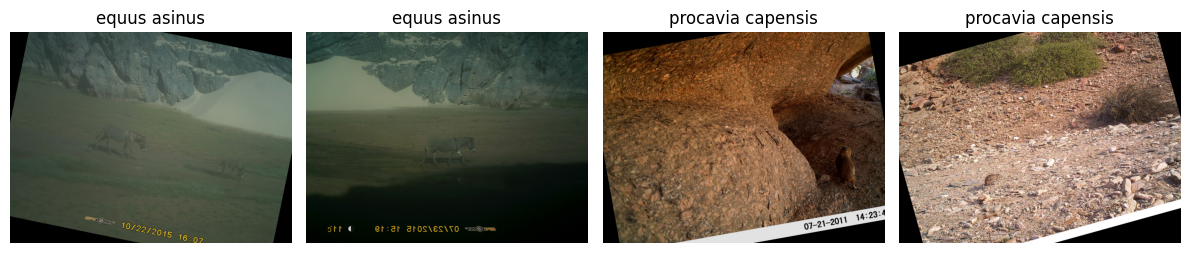

In [ ]:
# Pfade
base_path = "augmented_dataset_new"
categories = ["equus asinus", "procavia capensis"]
num_images = 2

# Beispielbilder sammeln
example_images = []

for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.exists(category_path):
        print(f"⚠️ Kategorieordner nicht gefunden: {category}")
        continue

    images = [f for f in os.listdir(category_path) if f.lower().endswith((".jpg", ".png"))]
    selected = random.sample(images, min(num_images, len(images)))
    
    for img_name in selected:
        img_path = os.path.join(category_path, img_name)
        print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        example_images.append((category, image))

# Anzeigen der Beispielbilder
plt.figure(figsize=(12, 6))
for idx, (label, img) in enumerate(example_images):
    plt.subplot(1, len(example_images), idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
file_names={
    "augmented_dataset_new/equus asinus/equus asinus_aug_92058286.jpg",
    "augmented_dataset_new/equus asinus/equus asinus_aug_234bd44e.jpg",
    "augmented_dataset_new/procavia capensis/procavia capensis_aug_5e784721.jpg",
    "augmented_dataset_new/procavia capensis/procavia capensis_aug_751a78bf.jpg"
}
for file in file_names:
    img_path = os.path.join(file).replace("\\", "/")
    print(img_path)

augmented_dataset_new/equus asinus/equus asinus_aug_92058286.jpg
augmented_dataset_new/procavia capensis/procavia capensis_aug_5e784721.jpg
augmented_dataset_new/equus asinus/equus asinus_aug_234bd44e.jpg
augmented_dataset_new/procavia capensis/procavia capensis_aug_751a78bf.jpg


In [ ]:
import json

# JSON-Datei laden
with open("JSONs/balanced_dataset_augmented.json", "r") as f:
    data = json.load(f)

# Pfade in data["images"] korrigieren
for img in data["images"]:
    corrected_file = img["file"].replace("\\", "/")
    if corrected_file.startswith("../") or corrected_file.startswith("..\\"):
        corrected_file = corrected_file.replace("../", "")
    img["file"] = corrected_file  # ✔ zurückschreiben

# Pfade in data["annotations"] korrigieren
for ann in data["annotations"]:
    corrected_id = ann["image_id"].replace("\\", "/")
    if corrected_id.startswith("../") or corrected_id.startswith("..\\"):
        corrected_id = corrected_id.replace("../", "")
    ann["image_id"] = corrected_id  # ✔ zurückschreiben

# Neue JSON speichern
with open("JSONs/balanced_dataset_augmented_clean.json", "w") as f:
    json.dump(data, f, indent=2)

print("✅ JSON mit bereinigten Pfaden gespeichert als 'balanced_dataset_augmented_clean.json'")


✅ JSON mit bereinigten Pfaden gespeichert als 'balanced_dataset_augmented_clean.json'


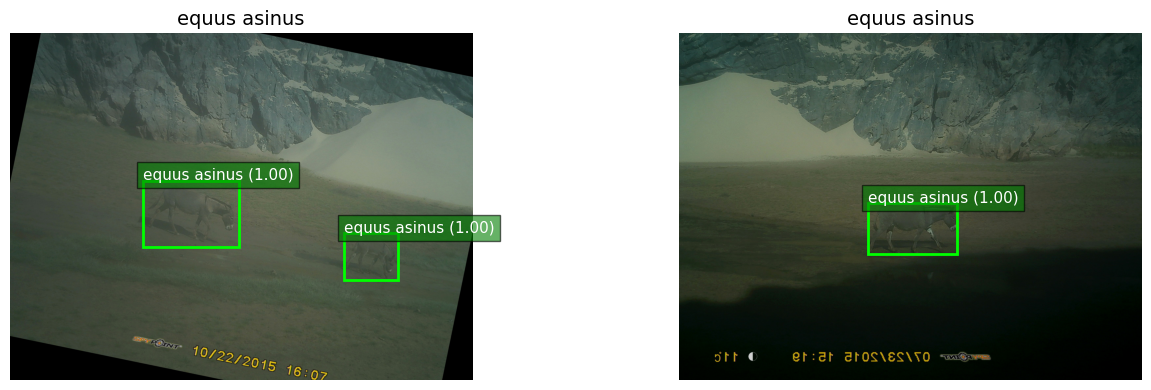

In [5]:
# Lade JSON mit bereinigten Pfaden
with open("JSONs/balanced_dataset_augmented_clean.json", "r") as f:
    data = json.load(f)

# Kategorie-Mapping (IDs sind Strings!)
category_id_to_name = {str(cat["id"]): cat["name"] for cat in data["categories"]}

# Bilder, die angezeigt werden sollen
selected_files = [
    "augmented_dataset_new/equus asinus/equus asinus_aug_92058286.jpg",
    "augmented_dataset_new/equus asinus/equus asinus_aug_234bd44e.jpg",
]

# Ordner mit den augmentierten Bildern
image_dir = "augmented_dataset_new"

# Mapping: file → detections
detections_by_file = {img["file"]: img.get("detections", []) for img in data["images"] if img["file"] in selected_files}

# Visualisierung: 1 Zeile mit 4 Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, file in zip(axes, selected_files):
    img_path = os.path.join( file).replace("\\", "/")
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Bild nicht gefunden: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h_img, w_img = img.shape[:2]

    ax.imshow(img)
    ax.set_title(file.split("/")[1], fontsize=14)
    ax.axis("off")

    detections = detections_by_file.get(file, [])
    for det in detections:
        x, y, w, h = det["bbox"]  # alle Werte normalisiert (0–1)
        confidence = det.get("conf", 1.0)
        category_name = category_id_to_name.get(str(det["category"]), "Unknown")

        # Umrechnen in absolute Koordinaten
        x1 = x * w_img
        y1 = y * h_img
        x2 = (x + w) * w_img
        y2 = (y + h) * h_img

        # Rechteck zeichnen
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # Label zeichnen
        label_text = f"{category_name} ({confidence:.2f})"
        ax.text(x1, y1 - 5, label_text, fontsize=11, color='white',
                bbox=dict(facecolor='green', alpha=0.6))

plt.tight_layout()
plt.savefig("figures/augmented_images_with_detections.pdf", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\vogel\AppData\Local\Temp\ipykernel_21960\4211208529.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


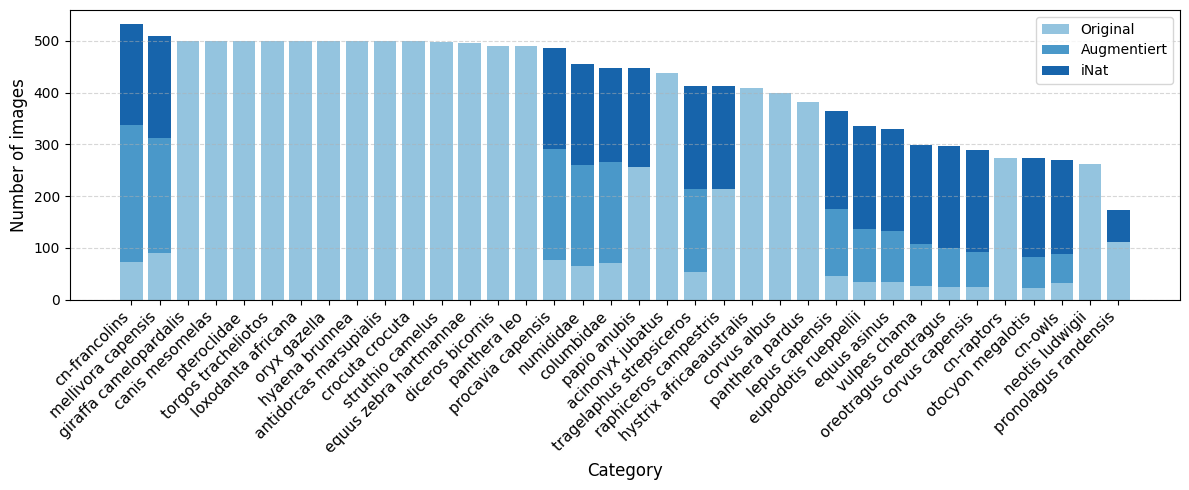

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

def count_images_recursive(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.lower().endswith((".jpg", ".jpeg", ".png"))])
    return count


image_root = "balanced_dataset"
aug_root = "augmented_dataset_new"
inat_root = "inat_images"


category_names = sorted(os.listdir(image_root))

original_counts = []
augmented_counts = []
inat_counts = []

for category in category_names:
    orig_path = os.path.join(image_root, category)
    aug_path = os.path.join(aug_root, category)

    # Um den passenden Ordner in inat_images zu finden:
    inat_category_name = category.replace(" ", "").lower()  # z.B. "wild boar" -> "wildboar"
    inat_dirs = os.listdir(inat_root)
    # versuche passenden Ordner zu finden, indem Unterstriche ignoriert werden
    inat_match = [d for d in inat_dirs if d.replace("_", "").lower() == inat_category_name]
    inat_path = os.path.join(inat_root, inat_match[0]) if inat_match else None

    # Zähle Bilder
    orig_count = count_images_recursive(orig_path)
    aug_count = count_images_recursive(aug_path)
    inat_count = count_images_recursive(inat_path) if inat_path else 0

    original_counts.append(orig_count)
    augmented_counts.append(aug_count)
    inat_counts.append(inat_count)


df_counts = pd.DataFrame({
    "Kategorie": category_names,
    "Original": original_counts,
    "Augmentiert": augmented_counts,
    "iNat": inat_counts
})

# Sortieren nach Gesamtanzahl (absteigend)
df_counts["Total"] = df_counts["Original"] + df_counts["Augmentiert"] + df_counts["iNat"]
df_counts = df_counts.sort_values("Total", ascending=False)


blues = cm.get_cmap("Blues")
color_original = blues(0.4)    # heller
color_augmented = blues(0.6)   # mittel
color_inat = blues(0.8)        # dunkler


plt.figure(figsize=(12, 5))

plt.bar(df_counts["Kategorie"], df_counts["Original"], label="Original", color=color_original)
plt.bar(df_counts["Kategorie"], df_counts["Augmentiert"],
        bottom=df_counts["Original"], label="Augmentiert", color=color_augmented)
plt.bar(df_counts["Kategorie"], df_counts["iNat"],
        bottom=df_counts["Original"] + df_counts["Augmentiert"], label="iNat", color=color_inat)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.ylabel("Number of images", fontsize=12)
plt.xlabel("Category", fontsize=12)
#plt.title("Distribution of Original, Augmented and iNaturalist Images per Category", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("figures/category_distribution_with_augm+inat.pdf", dpi=300, bbox_inches='tight')
plt.show()
